In [1]:
import h5py
import numpy
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from matplotlib import pyplot as plt
import itertools
import os

import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.ensemble as skens
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

#Local scripts
from data import DecompData
from features import Raws, Means, Moup, Covariances, AutoCovariances
from plotting import plots
from loading import load_task_data_as_pandas_df

#Progress Bar
from tqdm.notebook import tqdm

## Load/Extract session data

In [2]:
data_path = Path(os.path.abspath('')).parent / Path('data')
plot_path = Path(os.path.abspath('')).parent / Path('plots')

print(data_path)
if (not (data_path/'extracted_data.pkl').exists()):
    # load behavior data
    sessions = load_task_data_as_pandas_df.extract_session_data_and_save(root_paths=[data_path], mouse_ids=["GN06"], reextract=False)
    with open( data_path / 'extracted_data.pkl', 'wb') as handle:
        pkl.dump(sessions, handle)
else:
    # load saved data
    with open( data_path / 'extracted_data.pkl', 'rb') as handle:
        sessions = pkl.load(handle)
    print("Loaded pickled data.")

file_path = data_path / "GN06" / Path('2021-01-20_10-15-16/SVD_data/Vc.mat')
f = h5py.File(file_path, 'r')

frameCnt = np.array(f['frameCnt'])
trial_starts = np.cumsum(frameCnt[:-1, 1])
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts) )

B:\Master\ERS_calcium_analysis\data
Loaded pickled data.


## Define Conditions & additional Filters

In [3]:
#define different conds
modal_keys = ['visual', 'tactile', 'vistact']
modal_range = range(3)

side_keys = ['right', 'left']
side_range = range(2)

#filter for all conds
trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) & (svd.auto_reward == 0) & (svd.both_spouts == 1))

#set condition filter
cond_keys =  itertools.product(modal_keys,side_keys)
cond_keys_str = [f"{s}_{m}" for m, s in list(cond_keys)]
svd = svd[trial_preselection]
svd.conditions = [{"modality" : modal, "target_side_left" : side} for modal, side in itertools.product(modal_range,side_range)]

In [4]:
save_outputs = True
baseline_mode = None  #### basline mode ('mean' / 'zscore' / None)
comp = 10 ### number componants to use
n_rep = 10  ### number of folds
n_comp_LDA = None #5  ### number of LDA componants (conds -1)

In [5]:
feature_data = {}
    #"mean": [Means(svd.conditions[i,:,30:75],max_comps=comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond
    #"mean(-base)": [Means(svd.conditions[i,:,30:75]-Means(svd.conditions[i,:,15:30]),comp) for i in range(len(svd.conditions))],
    #"raw": [Raws(svd.conditions[i,:,30:75],comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond,
    #"cov": [Covariances(svd.conditions[i,:,30:75],max_comps=comp) for i in tqdm(range(len(svd.conditions)),desc='Conditions')], #mean of stimulusframes for first cond


for j in tqdm(range(0,2,1),desc="Time-lags for Cov and MOU-Process"):
    feature_data[r"Cov($\tau$="+str(j)+")"] =[AutoCovariances(svd.conditions[i,:,30:75],max_comps=comp,time_lag_range=[j],label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Cov(𝜏="+str(j)+")")]   
    if j>0:        
        feature_data[r'Mou($\tau$='+str(j)+")"] = [Moup(svd.conditions[i,:,30:75],max_comps=comp,time_lag=j,label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Mou(𝜏="+str(j)+")")]

features = feature_data.keys()
feature_label = list(features)

Time-lags for Cov and MOU-Process:   0%|          | 0/2 [00:00<?, ?it/s]

Cov(𝜏=0):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Cov(𝜏=1):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Mou(𝜏=1):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

In [6]:
cv = StratifiedShuffleSplit(n_rep, test_size=0.2, random_state=420)
perf = np.zeros([n_rep, len(features), 4])
classifiers = {}

for i_feat, feat in enumerate(tqdm(features,desc="Fit & score classifiers",position=0)):
  
    data = np.concatenate([f.flatten() for f in feature_data[feat]])
    labels = np.concatenate( [np.full((len(feature_data[feat][i].flatten())),cond_keys_str[i])
                                for i in range(len(feature_data[feat]))] )
    #feature_labels[feat]
    #for i in range(len(feature_data[feat])):
         #= feature_data[feat][i]



    scaler = preprocessing.StandardScaler().fit( data )
    data = scaler.transform(data)

    cv_split = cv.split(data, labels)

    c_MLR = skppl.make_pipeline(skppc.StandardScaler(),
                                skllm.LogisticRegression(C=1, penalty='l2', multi_class='multinomial',
                                                         solver='lbfgs',
                                                         max_iter=500))
    c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

    c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA, solver='eigen', shrinkage='auto')

    c_RF = skens.RandomForestClassifier(n_estimators=100, bootstrap=False)

    classifiers[feat]={"c_MLR":c_MLR.get_params()['steps'][1][1],"c_1NN":c_1NN,"c_LDA":c_LDA,"c_RF":c_RF}

    i = 0  ## counter
    for train_idx, test_idx in tqdm(cv_split,desc=feat,total=n_rep, leave=False, position=1):
        #print(f'\tRepetition {i:>3}/{n_rep}', end="\r" )
        c_MLR.fit(data[train_idx, :], labels[train_idx])
        c_1NN.fit(data[train_idx, :], labels[train_idx])
        c_LDA.fit(data[train_idx, :], labels[train_idx])
        c_RF .fit(data[train_idx, :], labels[train_idx])
        perf[i, i_feat, 0] = c_MLR.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 1] = c_1NN.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 2] = c_LDA.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 3] = c_RF.score(data[test_idx, :], labels[test_idx])
        i += 1
    #print(f'\tRepetition {n_rep:>3}/{n_rep}' )

Fit & score classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Cov($\tau$=0):   0%|          | 0/10 [00:00<?, ?it/s]

Cov($\tau$=1):   0%|          | 0/10 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Mou($\tau$=1):   0%|          | 0/10 [00:00<?, ?it/s]

Plotting Features:   0%|          | 0/3 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

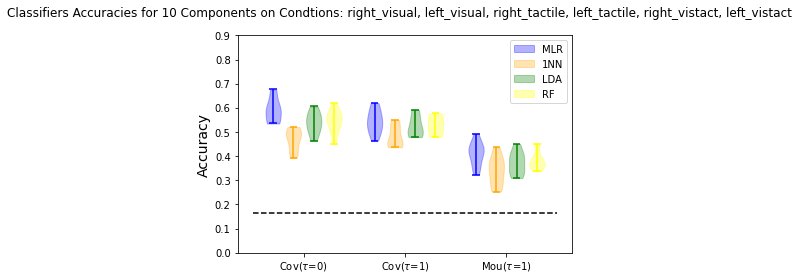

In [7]:

if save_outputs:
    np.save('perf_tasks.npy', perf)
plt.figure()
title = ' '.join(["Classifiers Accuracies","for",str(comp),"Components on Condtions:",', '.join(cond_keys_str)]) #str(len(svd.conditions)),"Conditions"])
plt.suptitle(title)


for i, feat in enumerate(tqdm(features,desc="Plotting Features")):
    v1 = plots.colored_violinplot(perf[:, i, 0], positions=np.arange(1) + i - 0.3, widths=[0.15], color="blue")
    v2 = plots.colored_violinplot(perf[:, i, 1], positions=np.arange(1) + i - 0.1, widths=[0.15], color="orange")
    v3 = plots.colored_violinplot(perf[:, i, 2], positions=np.arange(1) + i + 0.1, widths=[0.15], color="green")
    v4 = plots.colored_violinplot(perf[:, i, 3], positions=np.arange(1) + i + 0.3, widths=[0.15], color="yellow")
    if i == 0:
        plt.legend( [ v['bodies'][0] for v in [v1,v2,v3,v4]], [ "MLR", "1NN", "LDA","RF" ] )



plt.xticks(range(len(features)), [ feat for feat in feature_label ])
plt.plot([-.5, len(features)-.5], [1/len(svd.conditions), 1/len(svd.conditions)], '--k')
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('Accuracy', fontsize=14)

plt.savefig( plot_path/(title+".png") )
plt.show